# Flood Area Segmentation using UNet

### Import libraries

- We will use `segmentation_models_pytorch` : Python library with Neural Networks for Image Segmentation based on PyTorch.

In [1]:
! pip install -q segmentation-models-pytorch torchsummary
import segmentation_models_pytorch as smp

In [2]:
# Basic data manipulations
import cv2
import os
import shutil
from glob import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Handling images
from PIL import Image
import matplotlib.pyplot as plt

# Pytorch essentials
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.datasets import ImageFolder

# Pytorch essentials for datasets.
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2

# Data Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning

## Create dataframe

In [3]:
# add paths to the respective image and mask 
df = pd.read_csv('/kaggle/input/flood-area-segmentation/metadata.csv')
df['Image'] = [os.path.join('/kaggle/input/flood-area-segmentation/Image', i) for i in df['Image']]
df['Mask'] = [os.path.join('/kaggle/input/flood-area-segmentation/Mask', i) for i in df['Mask']]
df.head()

,Image,Mask
0,/kaggle/input/flood-area-segmentation/Image/0.jpg,/kaggle/input/flood-area-segmentation/Mask/0.png
1,/kaggle/input/flood-area-segmentation/Image/1.jpg,/kaggle/input/flood-area-segmentation/Mask/1.png
2,/kaggle/input/flood-area-segmentation/Image/2.jpg,/kaggle/input/flood-area-segmentation/Mask/2.png
3,/kaggle/input/flood-area-segmentation/Image/3.jpg,/kaggle/input/flood-area-segmentation/Mask/3.png
4,/kaggle/input/flood-area-segmentation/Image/4.jpg,/kaggle/input/flood-area-segmentation/Mask/4.png


## Data Visualization

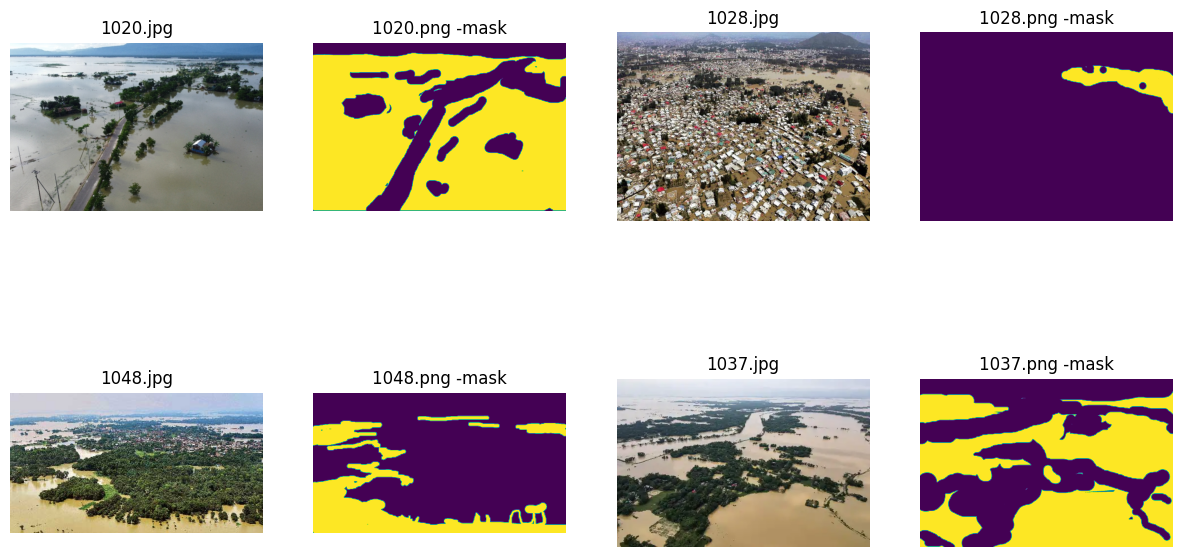

In [4]:
show_imgs = 4
idx = np.random.choice(len(df), show_imgs, replace=False)
fig, axes = plt.subplots(show_imgs*2//4, 4, figsize=(15, 8))
axes = axes.flatten()
for i, ax in enumerate(axes):
    new_i = i//2
    if i % 2 ==0 :
        full_path = df.loc[idx[new_i]]['Image']
        basename = os.path.basename(full_path) 
    else:
        full_path = df.loc[idx[new_i]]['Mask']
        basename = os.path.basename(full_path) + ' -mask' 
    ax.imshow(plt.imread(full_path))
    ax.set_title(basename)
    ax.set_axis_off()

## Create datasets and dataloaders

In [6]:
train_transforms = A.Compose([
    A.Resize(576, 576),
    A.RandomCrop(height=512, width=512, always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=(-0.04,0.04), rotate_limit=(-15,15), p=0.5),
    ]
    , is_check_shapes = False
)

test_transforms = A.Compose([
    A.Resize(512, 512),
    ],
    is_check_shapes = False
)

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms_=None):
        self.df = dataframe
        # We'll use transforms for data augmentation and converting PIL images to torch tensors.
        self.transforms_ = transforms_
        self.pre_normalize = v2.Compose([
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.resize = [512, 512]
        self.class_size = 2
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img = np.array(Image.open(self.df.iloc[index]['Image']).convert('RGB'))
        mask = np.array(Image.open(self.df.iloc[index]['Mask']).convert('L'))
        mask = np.where(mask<127, 0, 1).astype(np.int16)
        aug = self.transforms_(image=img, mask=mask)            
        img, mask = aug['image'], aug['mask']
        img = img/255
        img = self.pre_normalize(img)
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        target = torch.tensor(mask, dtype=torch.long)
        # print(f'img.shape : {img.shape}')
        # print(f'mask.shape : {mask.shape}')
        sample = {'x': img, 'y': target}
        return sample

In [14]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=9898)
train_dataset = MyDataset(train_df, train_transforms)
val_dataset = MyDataset(val_df, test_transforms)

BATCH_SIZE = 4
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
print(f'len train: {len(train_df)}')
print(f'len val: {len(val_df)}')

len train: 232
len val: 58


## Create model

In [28]:
class_size = 1 
model = smp.Unet(
    encoder_name="resnet50",        # other encoders VGG, MobileNet, InceptionNet, ViT
    encoder_weights="imagenet",     # `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=class_size,             # model output channels (number of classes in dataset)
)


model(torch.randn((1,3,512,512))).shape

torch.Size([1, 1, 512, 512])

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)
print(next(model.parameters()).device)

cuda
cuda:0


In [30]:
# print model summary
from torchsummary import summary 
summary(model, input_size=(3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]           4,096
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]          16,384
      BatchNorm2d-12        [-1, 256, 128, 128]             512
           Conv2d-13        [-1, 256, 128, 128]          16,384
      BatchNorm2d-14        [-1, 256, 1

## Training and validation

In [31]:
def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    model.train() # to training mode.
    epoch_loss = 0
    epoch_iou_score = 0
    for batch_i, batch in enumerate(dataloader):
        x, y = batch['x'].to(device), batch['y'].to(device) # move data to GPU
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)

        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        epoch_loss += loss.item() # tensor -> python value
        pred = pred.squeeze(dim=1)
        pred = torch.sigmoid(pred)
        y = y.round().long()
        tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=0.5)
        iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
        # print(f'train_acc: {acc}')
        epoch_iou_score += iou_score
        lr_scheduler.step()
    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_iou_score/num_batches



def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss = 0
    epoch_iou_score = 0
    # No gradient for test data
    with torch.no_grad():
        for batch_i, batch in enumerate(dataloader):
            x, y = batch['x'].to(device), batch['y'].to(device) # move data to GPU

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            pred = pred.squeeze(dim=1)
            pred = torch.sigmoid(pred)
            y = y.round().long()
            tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=0.5)
            iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
            # print(f'val_acc: {acc}')
            epoch_iou_score += iou_score
            # size += y.shape[0]
    return epoch_loss/num_batches, epoch_iou_score/num_batches

In [32]:
EPOCHS = 50
logs = {
    'train_loss': [], 'val_loss': [],
    'train_iou_score': [], 'val_iou_score': [],
}

if os.path.exists('checkpoints') == False:
    os.mkdir("checkpoints")
 
loss_fn = smp.losses.DiceLoss(mode="binary")

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 200, gamma=0.1)

# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

model.to(device)
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_iou_score = train(train_loader, model, loss_fn, optimizer, step_lr_scheduler)
    val_loss, val_iou_score = test(val_loader, model, loss_fn)
    logs['train_loss'].append(train_loss)
    logs['val_loss'].append(val_loss)
    logs['train_iou_score'].append(train_iou_score)
    logs['val_iou_score'].append(val_iou_score)

    
    print(f'EPOCH: {str(epoch+1).zfill(3)} \
    train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f} \
    train_iou_score: {train_iou_score:.3f}, val_iou_score: {val_iou_score:.3f} \
    lr: {optimizer.param_groups[0]["lr"]}')

    # On epoch end
    torch.save(model.state_dict(), "checkpoints/last.pth")
    # check improvement
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "checkpoints/best.pth")
    else:
        counter += 1
    if counter >= patience:
        print("Earlystop!")
        break

  0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 001     train_loss: 0.2780, val_loss: 0.8223     train_iou_score: 0.626, val_iou_score: 0.096     lr: 0.001


  2%|▏         | 1/50 [00:28<23:18, 28.54s/it]

EPOCH: 002     train_loss: 0.2069, val_loss: 0.1991     train_iou_score: 0.671, val_iou_score: 0.678     lr: 0.001


  4%|▍         | 2/50 [00:51<20:08, 25.19s/it]

EPOCH: 003     train_loss: 0.2086, val_loss: 0.1866     train_iou_score: 0.666, val_iou_score: 0.692     lr: 0.001


  6%|▌         | 3/50 [01:14<19:04, 24.34s/it]

EPOCH: 004     train_loss: 0.1924, val_loss: 0.1668     train_iou_score: 0.689, val_iou_score: 0.721     lr: 0.0001


  8%|▊         | 4/50 [01:38<18:23, 24.00s/it]

EPOCH: 005     train_loss: 0.1725, val_loss: 0.1682     train_iou_score: 0.716, val_iou_score: 0.719     lr: 0.0001


 10%|█         | 5/50 [02:00<17:40, 23.56s/it]

EPOCH: 006     train_loss: 0.1662, val_loss: 0.1570     train_iou_score: 0.725, val_iou_score: 0.735     lr: 0.0001


 12%|█▏        | 6/50 [02:23<17:05, 23.30s/it]

EPOCH: 007     train_loss: 0.1695, val_loss: 0.1534     train_iou_score: 0.719, val_iou_score: 0.739     lr: 1e-05


 14%|█▍        | 7/50 [02:46<16:40, 23.27s/it]

EPOCH: 008     train_loss: 0.1587, val_loss: 0.1556     train_iou_score: 0.734, val_iou_score: 0.737     lr: 1e-05


 16%|█▌        | 8/50 [03:09<16:06, 23.02s/it]

EPOCH: 009     train_loss: 0.1661, val_loss: 0.1622     train_iou_score: 0.723, val_iou_score: 0.729     lr: 1e-05


 18%|█▊        | 9/50 [03:31<15:36, 22.85s/it]

EPOCH: 010     train_loss: 0.1763, val_loss: 0.1528     train_iou_score: 0.713, val_iou_score: 0.741     lr: 1e-05


 20%|██        | 10/50 [03:54<15:11, 22.79s/it]

EPOCH: 011     train_loss: 0.1594, val_loss: 0.1617     train_iou_score: 0.733, val_iou_score: 0.729     lr: 1.0000000000000002e-06


 22%|██▏       | 11/50 [04:16<14:43, 22.64s/it]

EPOCH: 012     train_loss: 0.1569, val_loss: 0.1545     train_iou_score: 0.735, val_iou_score: 0.739     lr: 1.0000000000000002e-06


 24%|██▍       | 12/50 [04:39<14:20, 22.65s/it]

EPOCH: 013     train_loss: 0.1712, val_loss: 0.1572     train_iou_score: 0.717, val_iou_score: 0.735     lr: 1.0000000000000002e-06


 26%|██▌       | 13/50 [05:02<13:56, 22.61s/it]

EPOCH: 014     train_loss: 0.1563, val_loss: 0.1600     train_iou_score: 0.737, val_iou_score: 0.731     lr: 1.0000000000000002e-07


 28%|██▊       | 14/50 [05:24<13:33, 22.59s/it]

EPOCH: 015     train_loss: 0.1625, val_loss: 0.1509     train_iou_score: 0.728, val_iou_score: 0.743     lr: 1.0000000000000002e-07


 30%|███       | 15/50 [05:47<13:13, 22.68s/it]

EPOCH: 016     train_loss: 0.1578, val_loss: 0.1520     train_iou_score: 0.736, val_iou_score: 0.743     lr: 1.0000000000000002e-07


 32%|███▏      | 16/50 [06:10<12:49, 22.64s/it]

EPOCH: 017     train_loss: 0.1579, val_loss: 0.1507     train_iou_score: 0.735, val_iou_score: 0.744     lr: 1.0000000000000002e-07


 34%|███▍      | 17/50 [06:32<12:28, 22.68s/it]

EPOCH: 018     train_loss: 0.1604, val_loss: 0.1547     train_iou_score: 0.732, val_iou_score: 0.739     lr: 1.0000000000000004e-08


 36%|███▌      | 18/50 [06:55<12:04, 22.64s/it]

EPOCH: 019     train_loss: 0.1524, val_loss: 0.1569     train_iou_score: 0.742, val_iou_score: 0.735     lr: 1.0000000000000004e-08


 38%|███▊      | 19/50 [07:17<11:39, 22.55s/it]

EPOCH: 020     train_loss: 0.1621, val_loss: 0.1498     train_iou_score: 0.730, val_iou_score: 0.745     lr: 1.0000000000000004e-08


 40%|████      | 20/50 [07:40<11:15, 22.53s/it]

EPOCH: 021     train_loss: 0.1653, val_loss: 0.1528     train_iou_score: 0.725, val_iou_score: 0.741     lr: 1.0000000000000005e-09


 42%|████▏     | 21/50 [08:02<10:52, 22.49s/it]

EPOCH: 022     train_loss: 0.1566, val_loss: 0.1567     train_iou_score: 0.737, val_iou_score: 0.736     lr: 1.0000000000000005e-09


 44%|████▍     | 22/50 [08:24<10:27, 22.42s/it]

EPOCH: 023     train_loss: 0.1663, val_loss: 0.1518     train_iou_score: 0.724, val_iou_score: 0.742     lr: 1.0000000000000005e-09


 46%|████▌     | 23/50 [08:47<10:05, 22.41s/it]

EPOCH: 024     train_loss: 0.1615, val_loss: 0.1593     train_iou_score: 0.730, val_iou_score: 0.732     lr: 1.0000000000000005e-09


 48%|████▊     | 24/50 [09:09<09:40, 22.31s/it]

EPOCH: 025     train_loss: 0.1526, val_loss: 0.1630     train_iou_score: 0.743, val_iou_score: 0.727     lr: 1.0000000000000006e-10


 48%|████▊     | 24/50 [09:31<10:19, 23.82s/it]

Earlystop!


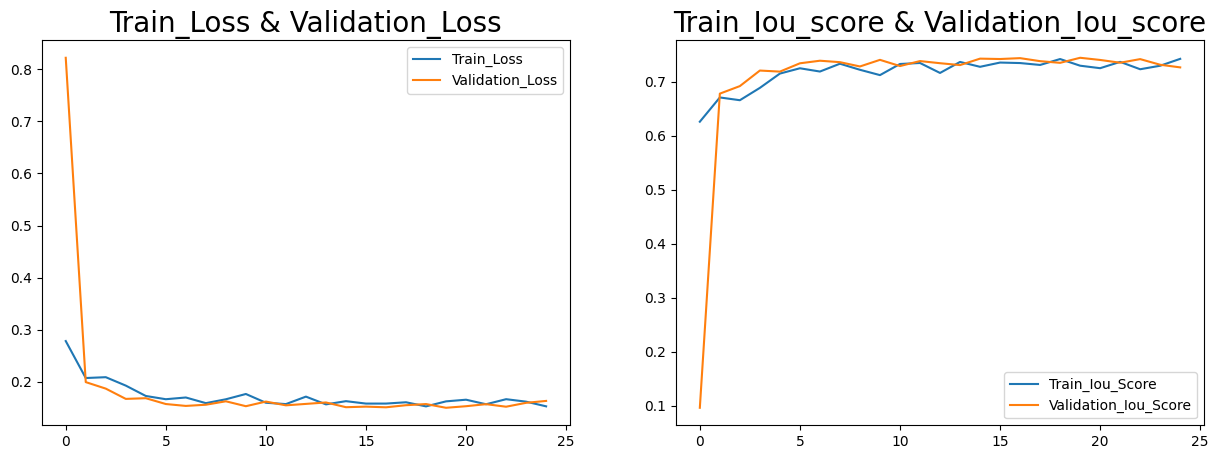

In [33]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(logs['train_loss'], label='Train_Loss')
plt.plot(logs['val_loss'], label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss', fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs['train_iou_score'], label='Train_Iou_Score')
plt.plot(logs['val_iou_score'], label='Validation_Iou_Score')
plt.title('Train_Iou_score & Validation_Iou_score', fontsize=20)
plt.legend()
plt.show()

## Metrics

In [34]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe,transforms_=None):
        self.df = dataframe
        self.transforms_ = transforms_
        self.pre_normalize = v2.Compose([
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.resize = [512, 512]
        self.class_size = 2
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img = cv2.cvtColor(cv2.imread(self.df.iloc[index]['Image']), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.df.iloc[index]['Mask'],cv2.IMREAD_GRAYSCALE)
        aug = self.transforms_(image=img, mask=mask)            
        img, mask = aug['image'], aug['mask']
        img_view = np.copy(img)
        img = img/255
        img = self.pre_normalize(img)
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        mask_view = np.copy(mask)
        mask = np.where(mask<127, 0, 1).astype(np.int16)
        target = torch.tensor(mask, dtype=torch.long)
        sample = {'x': img, 'y': target, 'img_view':img_view, 'mask_view':mask_view}
        return sample

test_dataset = TestDataset(val_df, test_transforms)
test_loader = DataLoader(test_dataset, batch_size=4)

In [35]:
model.load_state_dict(torch.load('checkpoints/best.pth'))
model.to(device)
def get_metrics(model, dataloder, threshold):
    IoU_score, precision, f1_score, recall, acc= 0, 0, 0, 0, 0
    batchs = 0
    model.eval()
    with torch.no_grad():
        for batch_i, batch in enumerate(dataloder):
            x, y = batch['x'].to(device), batch['y'].to(device) # move data to GPU
            pred = model(x)
            pred = pred.squeeze(dim=1)
            pred = torch.sigmoid(pred)
            y = y.round().long()
            tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=threshold)
            batch_iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
            batch_acc = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro").item()
            batch_f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro").item()
            batch_recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro").item()
            batch_precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro").item()
            IoU_score += batch_iou_score
            acc += batch_acc
            f1_score += batch_f1_score
            recall += batch_recall
            precision += batch_precision
            batchs += 1
    IoU_score = round(IoU_score/batchs, 3)
    precision = round(precision/batchs, 3)
    f1_score = round(f1_score/batchs, 3)
    recall = round(recall/batchs, 3)
    acc = round(acc/batchs, 3)
    sample = {'iou':IoU_score, 'pre':precision, 'fi':f1_score, 're':recall, 'acc':acc}
    return sample
    
threshold_list = [0.3, 0.4, 0.5, 0.6, 0.7]
for threshold in threshold_list:
    sample = get_metrics(model, test_loader, threshold)
    print(f"threshold: {str(threshold)} \
    IoU Score: {sample['iou']:.3f} \
    precision: {sample['pre']:.3f} \
    f1_score: {sample['fi']:.3f} \
    Recall: {sample['re']:.3f} \
    Acc: {sample['acc']:.3f}")

threshold: 0.3     IoU Score: 0.744     precision: 0.833     f1_score: 0.851     Recall: 0.879     Acc: 0.885
threshold: 0.4     IoU Score: 0.744     precision: 0.835     f1_score: 0.852     Recall: 0.877     Acc: 0.886
threshold: 0.5     IoU Score: 0.745     precision: 0.838     f1_score: 0.852     Recall: 0.875     Acc: 0.886
threshold: 0.6     IoU Score: 0.745     precision: 0.840     f1_score: 0.852     Recall: 0.873     Acc: 0.887
threshold: 0.7     IoU Score: 0.745     precision: 0.842     f1_score: 0.852     Recall: 0.871     Acc: 0.887


## Inference

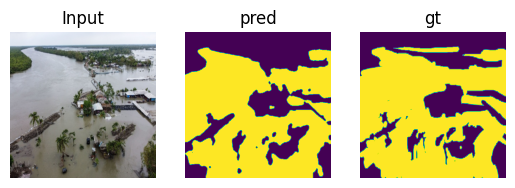

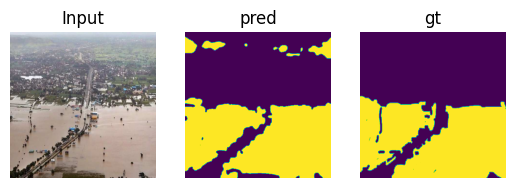

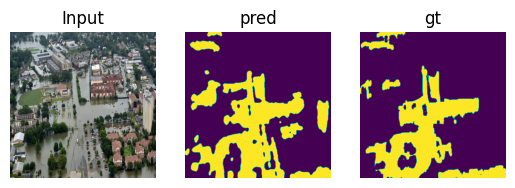

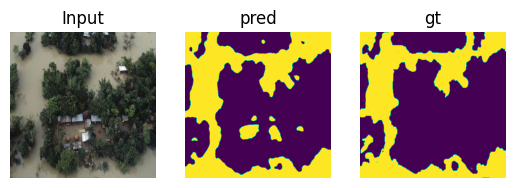

In [39]:
model.load_state_dict(torch.load("checkpoints/best.pth"))
model.to(device)
show_imgs = 4
random_list = np.random.choice(len(test_dataset), show_imgs, replace=False)

for i in range(show_imgs):
    idx = random_list[i]
    sample = test_dataset[idx]
    pred = model(sample['x'].to('cuda', dtype=torch.float32).unsqueeze(0))
    pred = torch.sigmoid(pred).squeeze(0).squeeze(0)
    pred = pred.data.cpu().numpy()
    pred = np.where(pred<0.5, 0, 1).astype(np.int16)
    pred_img = Image.fromarray(np.uint8(pred), 'L')

    img_view = sample['img_view']
    img_view = Image.fromarray(img_view, 'RGB')
    
    mask_view = sample['mask_view']
    mask_view = Image.fromarray(mask_view, 'L')
                
    f, axarr = plt.subplots(1, 3) 
    axarr[0].imshow(img_view)
    axarr[0].set_title('Input')
    axarr[0].axis('off')
    axarr[1].imshow(pred_img)
    axarr[1].set_title('pred')
    axarr[1].axis('off')
    axarr[2].imshow(mask_view)
    axarr[2].set_title('gt')
    plt.axis('off')
    plt.show()